# Advanced Uses

In [1]:
import numpy as np
import torch
from neurodiffeq import diff
from neurodiffeq.ode import solve, solve_system, Monitor, IVP

import matplotlib.pyplot as plt
%matplotlib notebook

## Tuning the Solver

The `ode.solve`, `ode.solve_system` and `pde.solve2D` choose some hyperparameters by default. For example, in `solve`, by default:
* the solution is approximated by a fully connected network with 1 hidden layer with 32 units (tanh activation),
* for each epoch we train on 16 different points that are generated by adding a Gaussian noise on the 32 equally spaced points on the $t$ domain,
* an Adam optimizer with learning rate 0.001 is used
Sometimes we may want to choose these hyperparameters ourselves. We will be using the harmonic oscillator problem from above to demonstrate how to do that.

In the following, we demo how to change these default settings using the harmonic oscillator as an example.

In [2]:
harmonic_oscillator = lambda x, t: diff(x, t, order=2) + x
init_val_ho = IVP(t_0=0.0, x_0=0.0, x_0_prime=1.0)

### Specifying the Networks

In [3]:
from neurodiffeq.networks import FCNN # fully-connect neural network
from torch import nn                  # PyTorch neural network module

We can pass a `torch.nn.Module` object as the `net` argument to `solve`. This specifies the network architecture we will use to approximate $x$. `neurodiffeq.networks.FCNN` is a fully connected network that has the same hidden units for each hidden layer. It can be initiated with the following arguments:

* `n_hidden_units`: number of units for each hidden layer. Each hidden layer's number of units will be the same.

* `n_hidden_layers`: number of hidden layers

* `actv`: a `torch.nn.Module` *class*. e.g. `nn.Tanh`, `nn.Sigmoid`.

Here we create a fully connected network with 2 hidden layers, each with 16 units and tanh activation. We then use it to fit our ODE solution.

<IPython.core.display.Javascript object>


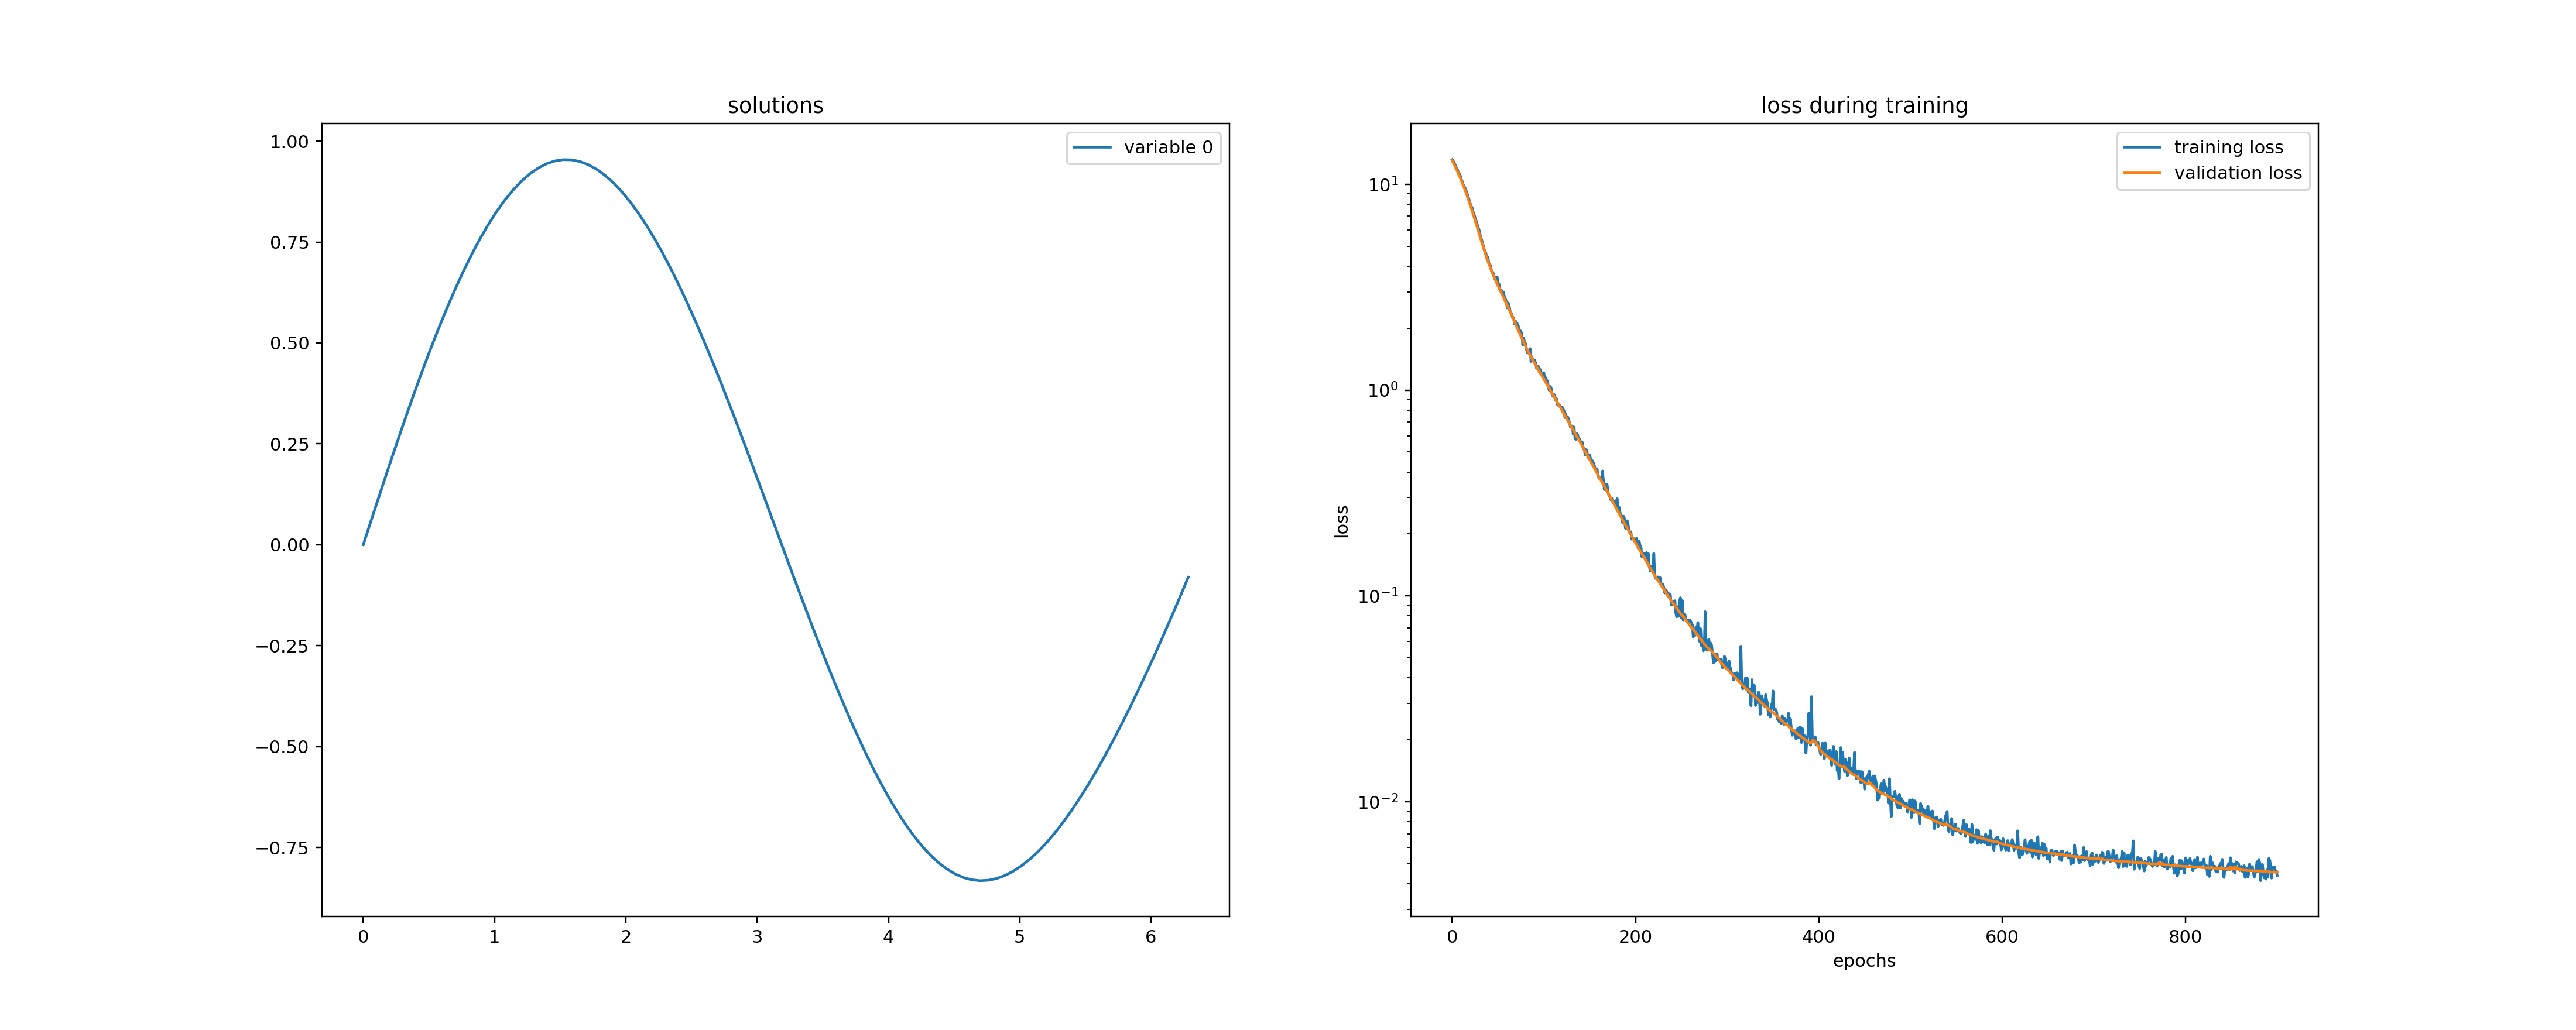

In [4]:
%matplotlib notebook
# specify the network architecture
net_ho = FCNN(
    n_hidden_layers=2, n_hidden_units=16, actv=nn.Tanh
)

# solve the ODE
solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho,  t_min=0.0, t_max=2*np.pi,
    net=net_ho,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

### Specifying the Training Set and Validation Set

`solve` and `solve_system` will train the neural network on a new set of examples. These examples are $t$s drawn from the domain of $t$. The way these $t$s are generated can be specified by passing a `neurodiffeq.ode.ExampleGenerator` object as the `train_generator` argument (and `valid_generator` argument) to `solve` or `solve_system`. An `ExampleGenerator` can be initiated by the following arguments:

* `size`: the number of $t$s generated for each epoch

* `t_min` and `t_max`: the domain of $t$ from which we want to draw $t$s

* `method`: a string indicating how to generate the $ts$. It should be one of the following: 'uniform', 'equally-spaced', 'equally-spaced-noisy'. If 'uniform', each $t$ will be drawn independently from the uniform distribution $\text{Unif}($`t_min`, `t_max`$)$. If 'equally-spaced', all $t$s generated in the same epoch will form a grid where each $t$ is equally spaced. 'equally-spaced-noisy' is a noisy version of 'equally-spaced' where we add a Gaussian noise $\epsilon \sim \mathcal{N}(0, ($`t_max`-`t_min`)/(4*`size`) $)$

Here we create an `ExampleGenerator` that generates 64 $t$s drawn from a uniform distribution for every epoch. Then we use it to solve the ODE. In the meantime, foor every epoch, we will use another `ExampleGenerator` that generates 128 $t$s that are equally spaced in the domain we want to solve.

In [5]:
from neurodiffeq.ode import ExampleGenerator

<IPython.core.display.Javascript object>


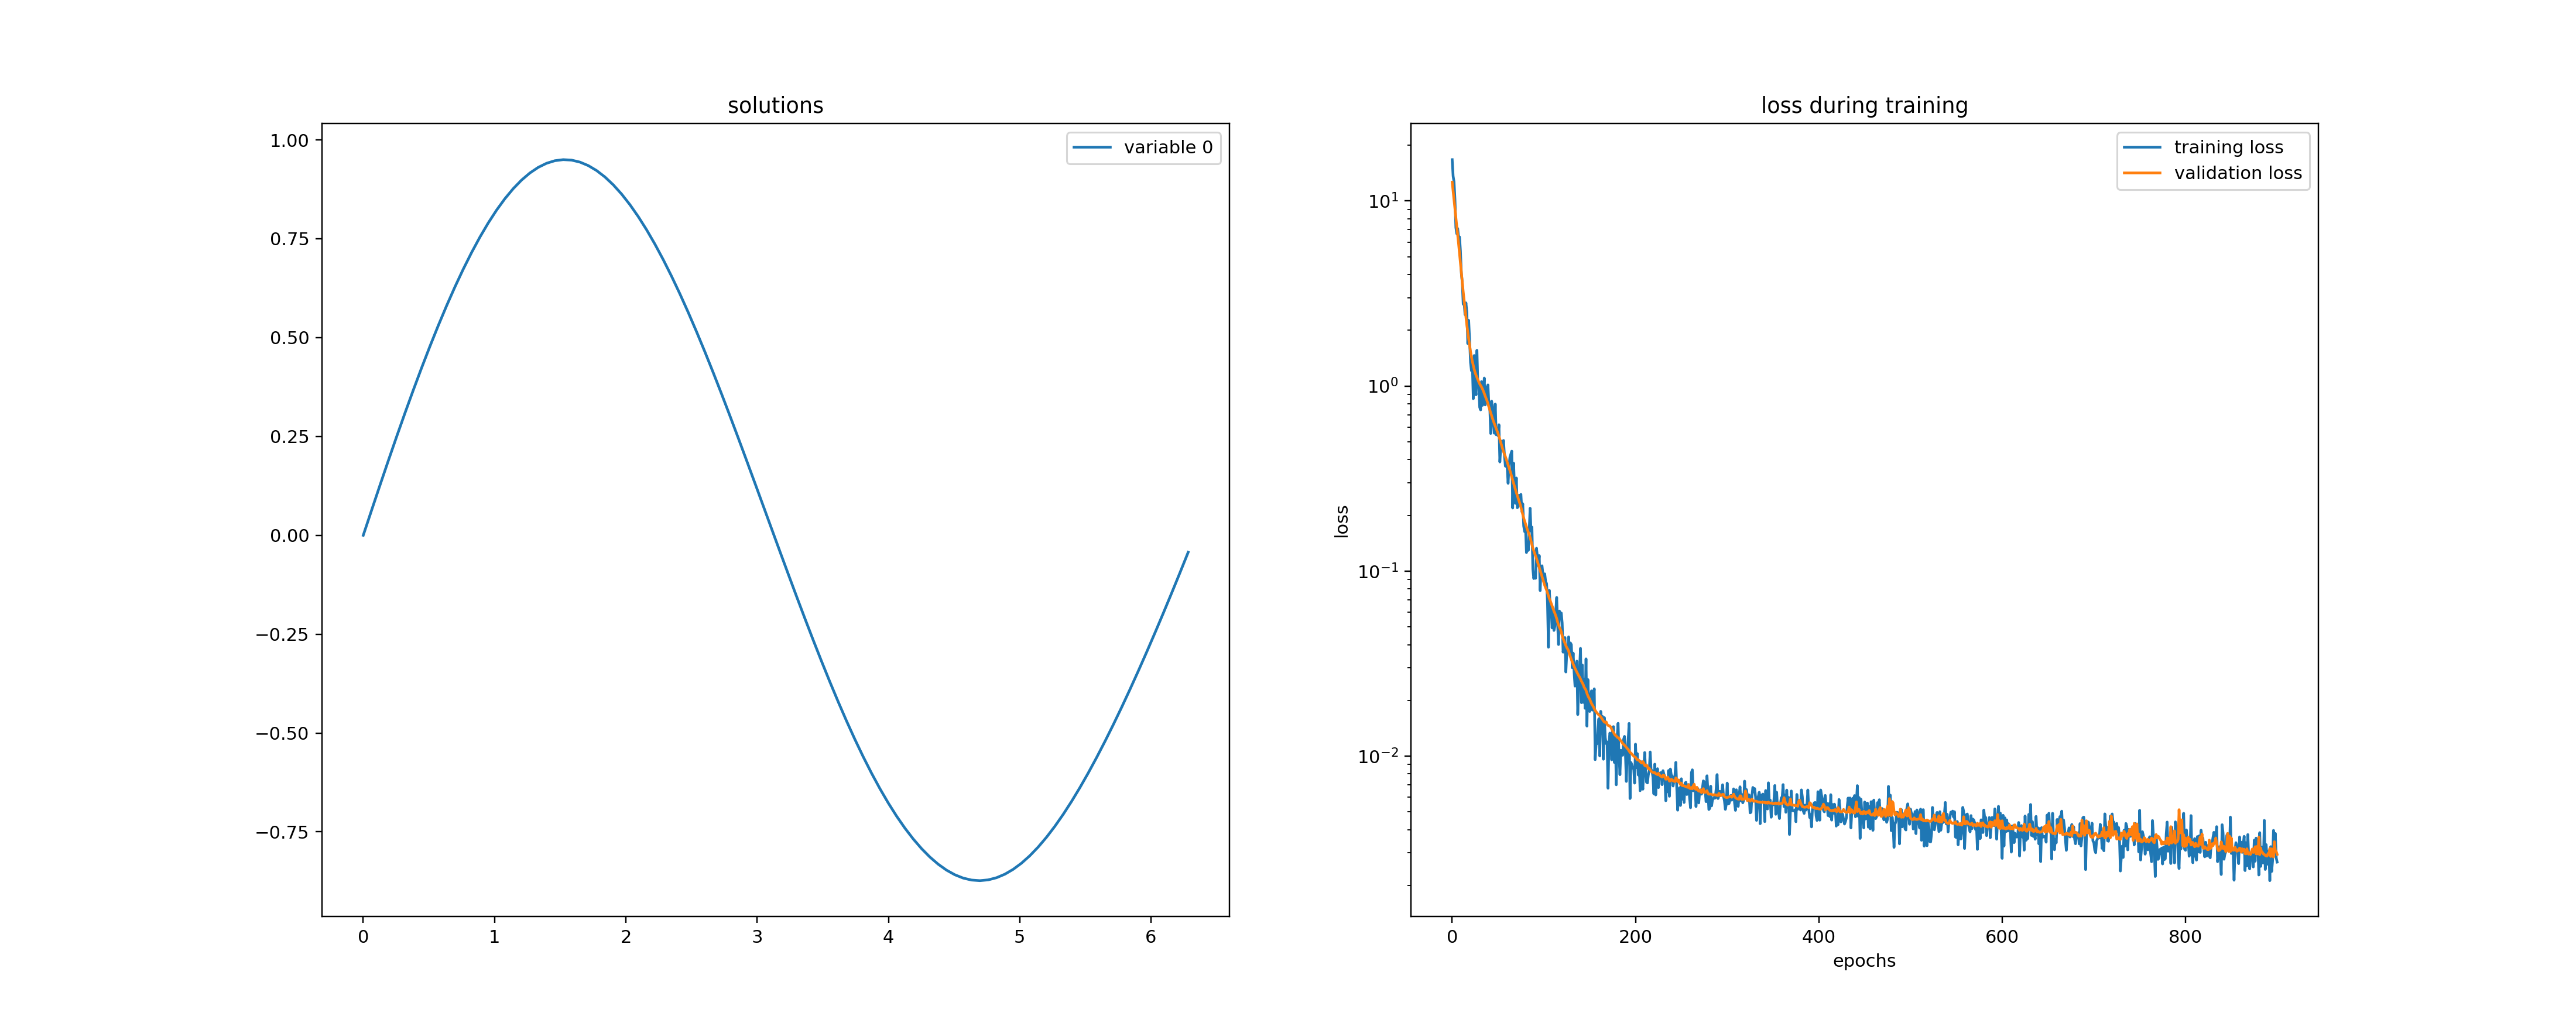

In [6]:
%matplotlib notebook
# specify the training set and validation set
train_gen = ExampleGenerator(size=64,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = ExampleGenerator(size=128, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# solve the ODE
solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    train_generator=train_gen, valid_generator=valid_gen,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

###  Specifying the Optimizer

We can change the optimization algorithms by passing a `torch.optim.Optimizer` object to `solve` and `solve_system` as the `optimizer` argument. The ugly thing here is that, to initiate an `Optimizer`, we need to tell it the parameters to optimize. In other words, if we want to use a different optimizer from the default one, we also need to create our own networks. 

Here we create a fully connected network and an `SGD` optimizer to optimize its weights. Then we use them to solve the ODE.

In [7]:
from torch.optim import SGD

<IPython.core.display.Javascript object>


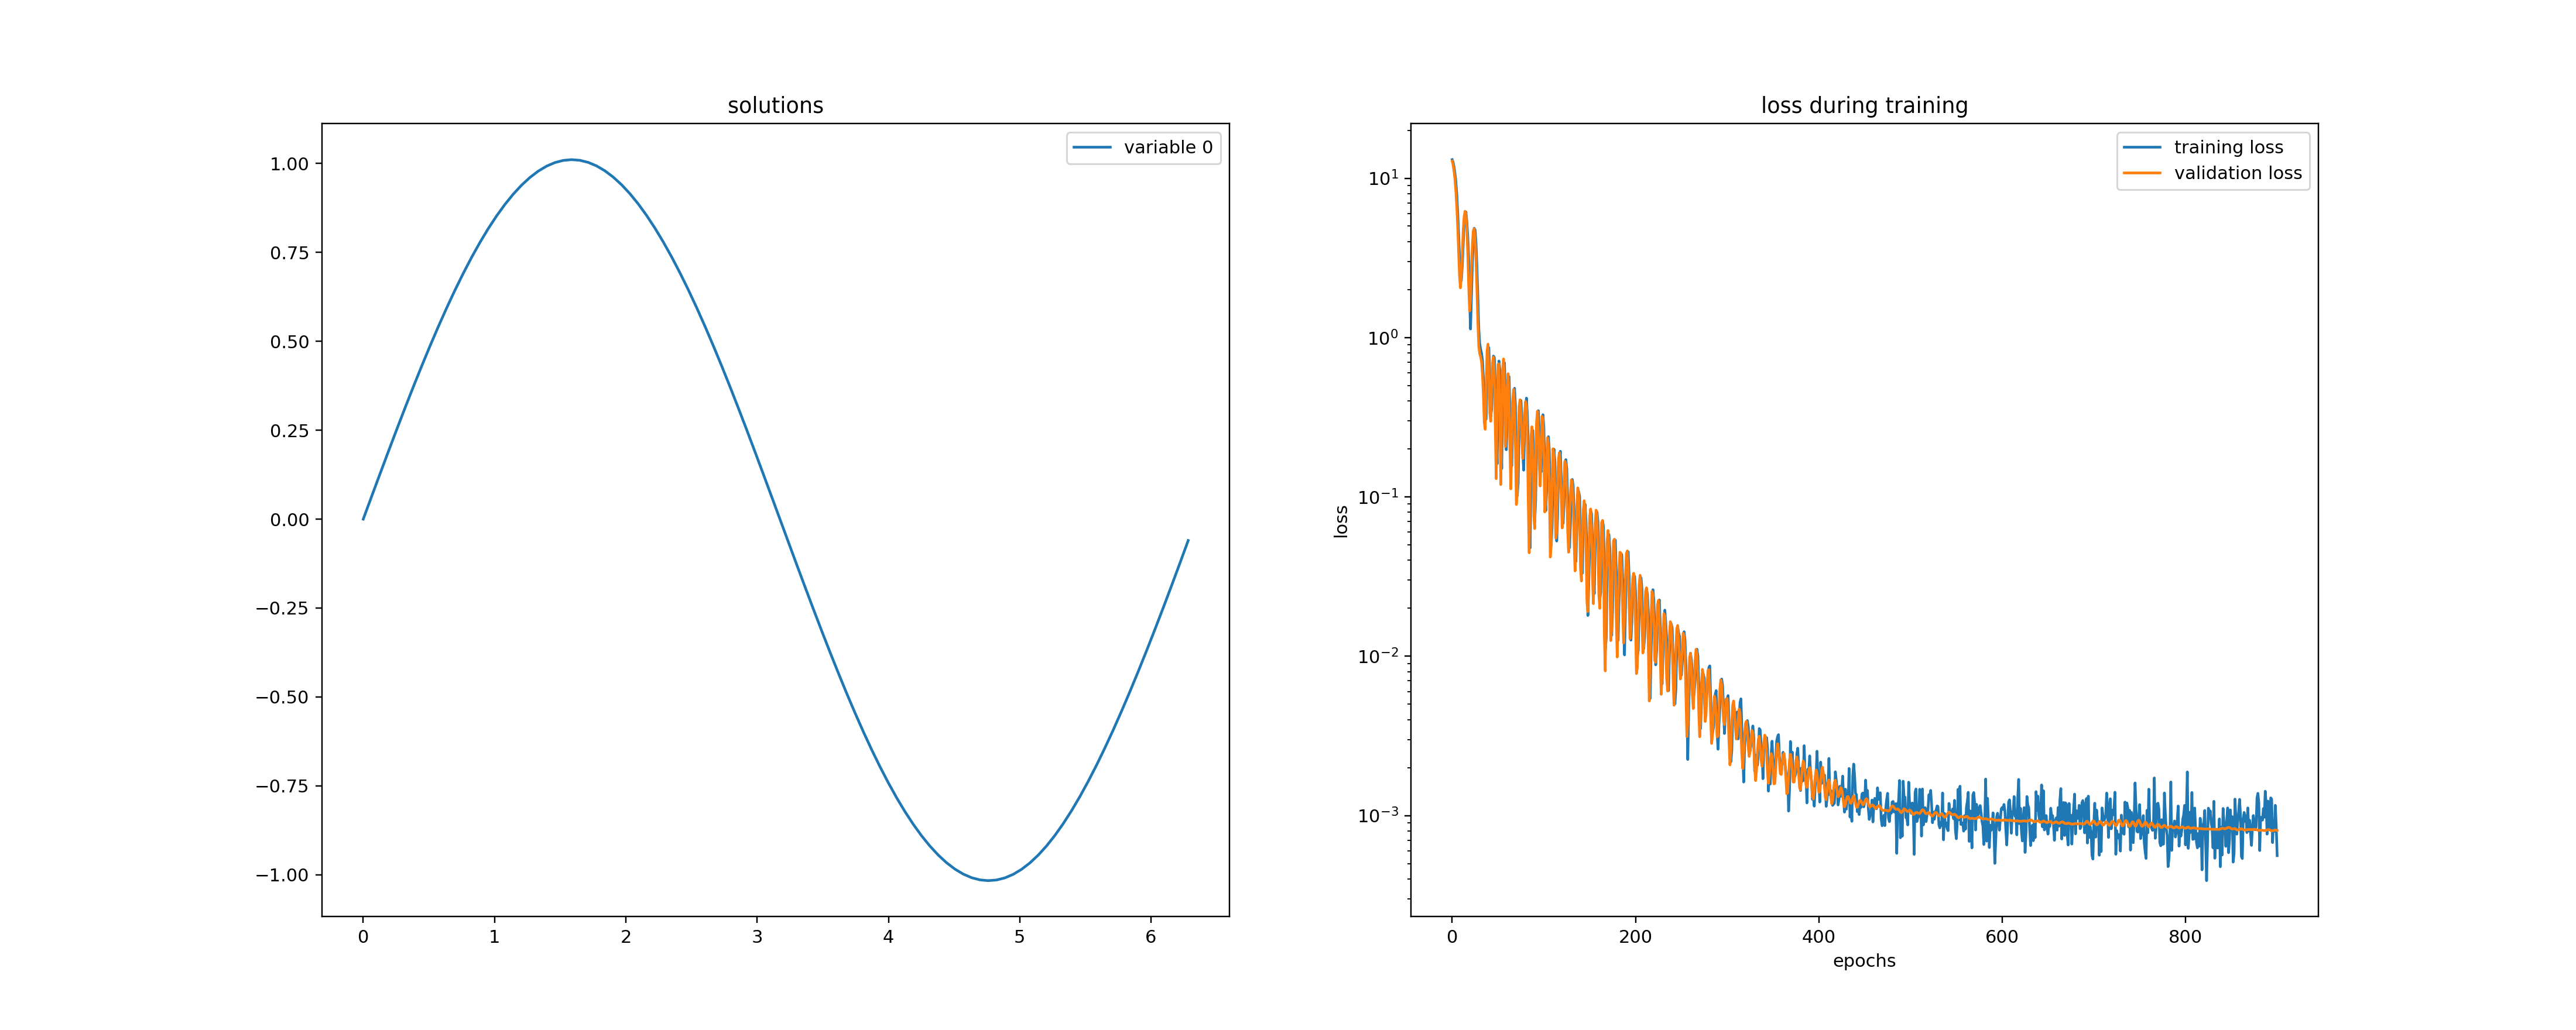

In [8]:
%matplotlib notebook
# specify the network architecture
net_ho = FCNN(
    n_hidden_layers=2, n_hidden_units=16, actv=nn.Tanh
)

# specify the optimizer
sgd_ho = SGD(net_ho.parameters(), lr=0.001, momentum=0.99)

# solve the ODE
solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    net=net_ho, optimizer=sgd_ho,
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

### Specifying the Loss Function

We can change the loss function by passing a `torch.nn._Loss` object to `solve` and `solve_system` as the `criterion` argument. 

Here we use the mean absolute loss to solve the ODE.

In [9]:
from torch.nn import L1Loss

<IPython.core.display.Javascript object>


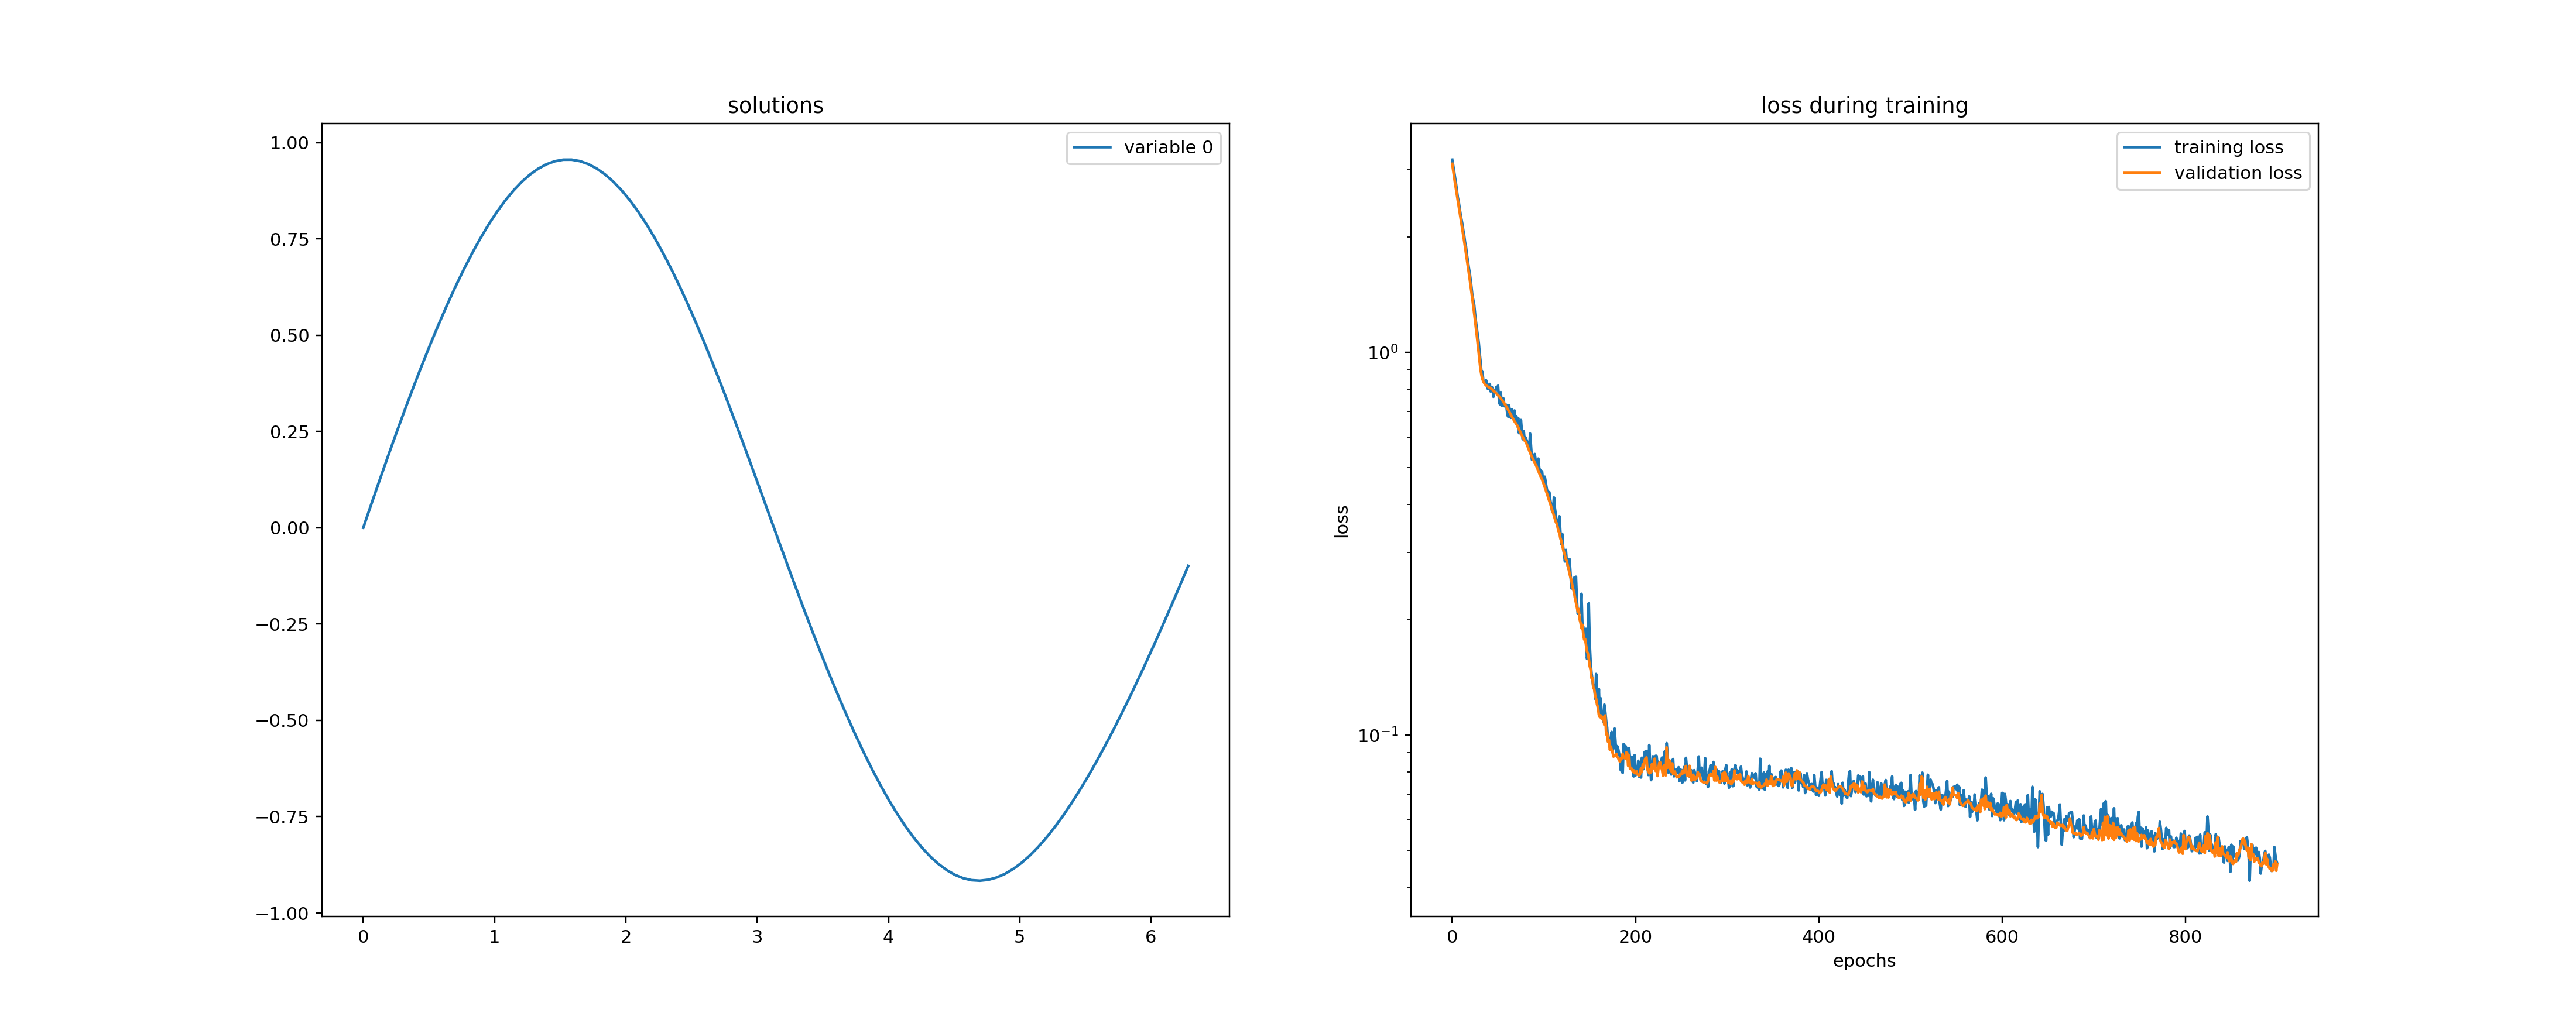

In [10]:
%matplotlib notebook
# solve the ODE
solution_ho, _ = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi,
    criterion=L1Loss(),
    monitor=Monitor(t_min=0.0, t_max=2*np.pi, check_every=100)
)

## Access the Internals

When the network, example generator, optimizer and loss function are specified outside `solve` and `solve_system` function, users will naturally have access to these objects. We may still want to access these objects when we are using default network architecture, example generator, optimizer and loss function. We can get these internal objects by setting the `return_internal` keyword to `True`. This will add a third element in the returned tuple, which is a dictionary containing the reference to the network, example generator, optimizer and loss function.

In [11]:
# specify the ODE system
parametric_circle = lambda x1, x2, t : [diff(x1, t) - x2, 
                                        diff(x2, t) + x1]
# specify the initial conditions
init_vals_pc = [
    IVP(t_0=0.0, x_0=0.0),
    IVP(t_0=0.0, x_0=1.0)
]

# solve the ODE system
solution_pc, _, internal = solve_system(
    ode_system=parametric_circle, 
    conditions=init_vals_pc, 
    t_min=0.0, t_max=2*np.pi,
    return_internal=True
)

In [12]:
internal

{'nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  ), FCNN(
    (NN): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )],
 'conditions': [<neurodiffeq.ode.IVP at 0x12be877b8>,
 'train_generator': <neurodiffeq.ode.ExampleGenerator at 0x12be87160>,
 'valid_generator': <neurodiffeq.ode.ExampleGenerator at 0x12a468d30>,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ),
 'criterion': MSELoss()}